In [70]:
# Import standard libraries
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, MonthLocator
import seaborn as sns
import warnings
import requests
import itertools
import random
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Import data analysis and signal processing libraries
from scipy.stats import mstats
from scipy.signal import argrelextrema
from tqdm import tqdm, tnrange, notebook
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

# Import asynchronous libraries
import asyncio
import aiohttp

# Import machine learning libraries
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras import callbacks
import talib
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

# Import Backtesting library
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

# Set seaborn style
sns.set()

# Filter out warnings
warnings.filterwarnings("ignore")


# Importing data and creating train-test split

In [71]:
prices = pd.read_csv('./coin_data.csv', index_col=0)
prices = prices.astype(float)
prices.index = pd.to_datetime(prices.index)

split = int(len(prices)*0.8)
train_prices = prices[:split]
test_prices = prices[split:]

# Choosing cointegrated pair

       scores   pvalues                  pairs
102 -4.182042  0.003883  (DOGEUSDT, MATICUSDT)
39  -4.176122  0.003964     (DOTUSDT, CRVUSDT)
14  -3.558762  0.027530    (XMRUSDT, AAVEUSDT)
19  -3.445207  0.037572     (XMRUSDT, UNIUSDT)
90  -3.371645  0.045599     (BNBUSDT, ADAUSDT)


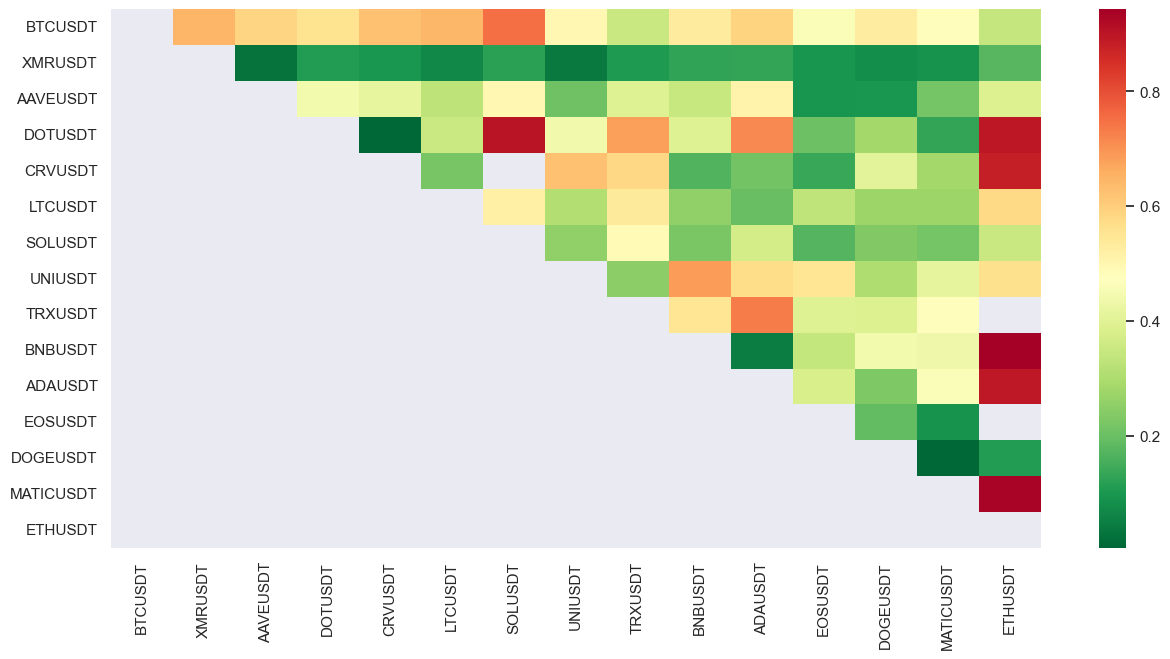

In [72]:
def find_cointegrated_pairs(data, conf=0.05):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < conf:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

# used vectorization
def find_cointegrated_pairs_v3(data, conf=0.05):
    n = data.shape[1]
    keys = data.columns
    pairs = []
    scores = np.zeros((n * (n - 1)) // 2)  # Initialize as a 1D NumPy array
    pvalues = np.ones((n * (n - 1)) // 2)  # Initialize as a 1D NumPy array
    
    idx = 0  # Index for storing results in the arrays
    
    for i in range(n):
        for j in range(i + 1, n):
            S1 = data[keys[i]].values  # Convert to NumPy array
            S2 = data[keys[j]].values  # Convert to NumPy array
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            
            scores[idx] = score
            pvalues[idx] = pvalue
            pairs.append((keys[i], keys[j]))
            
            idx += 1
    
    coint_pairs = pd.DataFrame({'scores': scores, 'pvalues': pvalues, 'pairs': pairs})
    coint_pairs = coint_pairs[coint_pairs['pvalues'] < conf]
    
    return coint_pairs.sort_values('pvalues')

# Usage example
scores, pvalues, pairs = find_cointegrated_pairs(train_prices)
cointegrated_pairs = find_cointegrated_pairs_v3(train_prices)
print(cointegrated_pairs)

plt.figure(figsize=(15,7))

sns.heatmap(pvalues, xticklabels=prices.columns, 
                yticklabels=prices.columns, cmap='RdYlGn_r', 
                mask = (pvalues >= 0.95))

plt.show()


In [73]:
pair = cointegrated_pairs.iloc[0]['pairs']
P1 = pair[0]
P2 = pair[1]
print('Best pair: ', P1, P2)

Best pair:  DOGEUSDT MATICUSDT


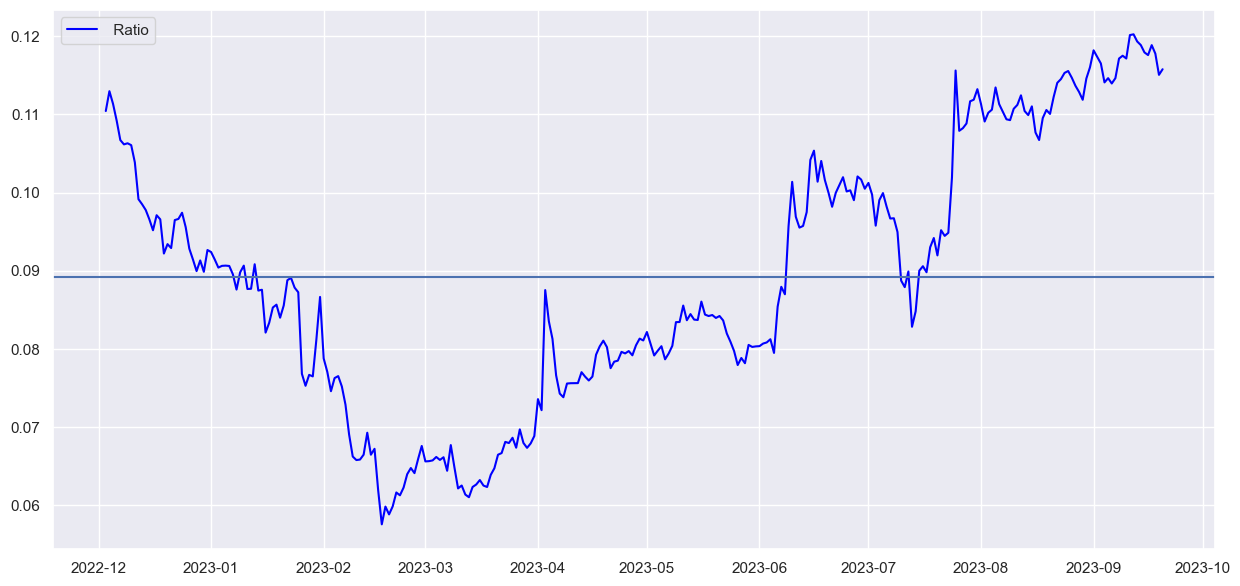

Mean ratio (DOGEUSDT/MATICUSDT): 0.0891


In [74]:
# Finding the ratio for DOGE / MATIC

S1 = train_prices[P1]
S2 = train_prices[P2]

score, pvalue, _ = coint(S1, S2)
ratios = S1 / S2

plt.figure(figsize=(15,7))

plt.plot(ratios.index, ratios, color='blue')
plt.axhline(ratios.mean())
plt.legend([' Ratio'])
plt.show()

print(f'Mean ratio ({P1}/{P2}): {ratios.mean():.4f}')

# Backtesting

In [75]:
def trade(P1, P2, near, far, initial_capital=10000, commission_rate=0.01, test=False, verbose=False):
    if (near == 0) or (far == 0) or (near >= far):
        return 0

    if test:
        if verbose:
            print('Trade on Testing Data\n')
        price1 = test_prices[P1]
        price2 = test_prices[P2]
    else:
        if verbose:
            print('Trade on Training Data\n')
        price1 = train_prices[P1]
        price2 = train_prices[P2]

    ratios = price1 / price2
    ma1 = ratios.rolling(window=near, center=False).mean()
    ma2 = ratios.rolling(window=far, center=False).mean()
    std = ratios.rolling(window=far, center=False).std()
    zscore = (ma1 - ma2) / std

    money = initial_capital
    countS1 = 0
    countS2 = 0
    drawdown = 0
    transactions = []
    
    # Store prices in variables to avoid redundant access
    prices1 = price1.values
    prices2 = price2.values

    for i in range(len(ratios)):
        capital_per_asset = money / 2
        qty1 = capital_per_asset // prices1[i]
        qty2 = capital_per_asset // prices2[i]
        
        # Calculate the commission for buying or selling
        def calculate_commission(price, quantity):
            return price * quantity * commission_rate

        transaction_value1 = qty1 * prices1[i]
        transaction_value2 = qty2 * prices2[i]
        commission = calculate_commission(prices1[i], qty1) + calculate_commission(prices2[i], qty2)

        # Sell short P1 and long P2 if z-score > 1
        if zscore[i] < -1 and countS1 == 0 and countS2 == 0:
            money += transaction_value1 - transaction_value2 - commission
            countS1 -= qty1
            countS2 += qty2
            opendatetime = ratios.index[i]
            transactions.append(logTxn(opendatetime, 'Sell', P1, prices1[i], qty1,
                                       'Buy', P2, prices2[i], qty2, zscore[i], 1, money))

        # Buy long P1 and short P2 if z-score < -1
        elif zscore[i] > 1 and countS1 == 0 and countS2 == 0:
            money -= transaction_value1 - transaction_value2 + commission
            countS1 += qty1
            countS2 -= qty2
            opendatetime = ratios.index[i]
            transactions.append(logTxn(opendatetime, 'Buy', P1, prices1[i], qty1,
                                       'Sell', P2, prices2[i], qty2, zscore[i], 1, money))

        # Close all positions if z-score between -0.75 and 0.75
        elif abs(zscore[i]) < 0.7 and (countS1 != 0 or countS2 != 0):
            transaction_value1 = countS1 * prices1[i]
            transaction_value2 = countS2 * prices2[i]
            commission = calculate_commission(prices1[i], abs(countS1)) + calculate_commission(prices2[i], abs(countS2))
            money += transaction_value1 + transaction_value2 - commission
            closedatetime = ratios.index[i]
            holdingperiod = closedatetime - opendatetime
            transactions.append(logTxn(closedatetime, 'Close', P1, prices1[i], countS1,
                                       'Close', P2, prices2[i], countS2, zscore[i], 1, money, drawdown, holdingperiod))
            countS1 = 0
            countS2 = 0
            drawdown = 0

        drawdown = min(money, drawdown)

    return transactions

def logTxn(datetime, action1, coin1, price1, qty1, action2, coin2, price2, qty2, zscore, hedgeratio, pnl, drawdown=0, holdingperiod=timedelta(0)):
    txn = {'datetime': datetime, 'action1': action1, 'coin1': coin1, 'price1': price1, 'qty1': qty1,
           'action2': action2, 'coin2': coin2, 'price2': price2, 'qty2': qty2, 'zscore': zscore,
           'hedgeratio': hedgeratio, 'pnl': pnl, 'drawdown': drawdown, 'holdingperiod': holdingperiod}
    return txn

def showResults(txn):
    
    txn = pd.DataFrame.from_dict(txn)
    txn = txn[['datetime', 'action1', 'coin1', 'price1', 'qty1',
               'action2', 'coin2', 'price2', 'qty2', 
               'zscore', 'hedgeratio', 'pnl', 'drawdown', 'holdingperiod']]
    txn = txn.set_index('datetime')    
    
    plt.figure(figsize=(15,7))
    plt.plot(txn.pnl.index, txn.pnl)    

    ax = plt.gca()
    formatter = DateFormatter("%Y-%m")
    ax.xaxis.set_major_formatter(formatter)
    locator = MonthLocator()
    ax.xaxis.set_major_locator(locator)    
    
    plt.show()

    # Calculate daily returns
    txn['daily_returns'] = txn['pnl'].pct_change().fillna(0)
    
    # Calculate VaR at the 95% confidence level
    var_95 = np.percentile(txn['daily_returns'], 5)
    print(f'Value at Risk (95%): {var_95:.2%}')

    # Calculate Expected Shortfall at the 95% confidence level
    es_95 = txn['daily_returns'][txn['daily_returns'] <= var_95].mean()
    print(f'Expected Shortfall (95%): {es_95:.2%}')


    print('Profit/Loss: {:.2f}'.format(txn.iloc[-1].pnl))
    print('Maximum Drawdown: {:.2f}'.format(min(txn.drawdown)))
    print('Maximum Holding Period: {}'.format(max(txn.holdingperiod)))
    
    return txn

def optimize_portfolio(historical_returns):
    # Check for NaNs and clean the data
    if historical_returns.isnull().values.any():
        print("Data contains NaNs. Need to clean the data.")
        historical_returns = historical_returns.dropna()  # Drop NaN values

    # Calculate expected returns and sample covariance matrix
    mu = expected_returns.mean_historical_return(historical_returns)
    S = risk_models.sample_cov(historical_returns)

    # Ensure that the covariance matrix is symmetric
    # Sometimes, due to numerical precision issues, the matrix might not be perfectly symmetric.
    # One way to enforce symmetry is to average the matrix with its transpose.
    if not np.allclose(S, S.T, atol=1e-8):
        print("Covariance matrix is not symmetric. Enforcing symmetry.")
        S = (S + S.T) / 2  # Force symmetry
    
    # Optimize for the maximal Sharpe ratio
    # Creating the EfficientFrontier object with the symmetric covariance matrix
    ef = EfficientFrontier(mu, S)
    try:
        weights = ef.max_sharpe()
    except ValueError as e:
        print(f"An error occurred while finding max Sharpe ratio: {e}")
        return None, None
    
    cleaned_weights = ef.clean_weights()
    performance = ef.portfolio_performance(verbose=True)
    return cleaned_weights, performance

# Calculate historical returns for P1 and P2
def calculate_historical_returns(price1, price2):
    # Assuming price1 and price2 are pandas Series with DatetimeIndex
    returns1 = price1.pct_change().dropna()
    returns2 = price2.pct_change().dropna()
    returns = pd.DataFrame({'Asset1': returns1, 'Asset2': returns2})
    return returns
    

  0%|          | 0/400 [00:00<?, ?it/s]

Best Parameters: Near: 5, Far: 50


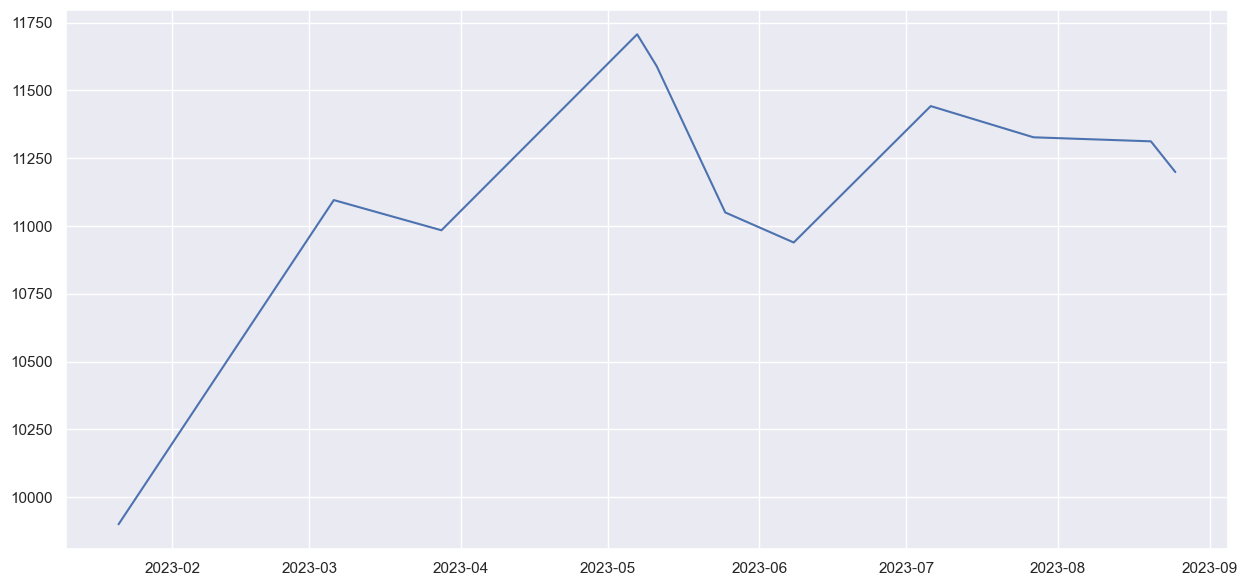

Value at Risk (95%): -2.83%
Expected Shortfall (95%): -4.65%
Profit/Loss: 11198.80
Maximum Drawdown: 0.00
Maximum Holding Period: 44 days 00:00:00


,action1,coin1,price1,qty1,action2,coin2,price2,qty2,zscore,hedgeratio,pnl,drawdown,holdingperiod,daily_returns
datetime,,,,,,,,,,,,,,
2023-01-21,Sell,DOGEUSDT,0.08467,59052.0,Buy,MATICUSDT,0.9897,5052.0,-1.240850,1,9899.969468,0,0 days,0.000000
2023-03-06,Close,DOGEUSDT,0.07479,-59052.0,Close,MATICUSDT,1.1309,5052.0,-0.664185,1,11095.479129,0,44 days,0.120759
2023-03-28,Buy,DOGEUSDT,0.07381,75162.0,Sell,MATICUSDT,1.0860,5108.0,1.129420,1,10984.109957,0,0 days,-0.010037
2023-05-07,Close,DOGEUSDT,0.07652,75162.0,Close,MATICUSDT,0.9636,-5108.0,0.672511,1,11706.702746,0,40 days,0.065785
2023-05-11,Buy,DOGEUSDT,0.07193,81375.0,Sell,MATICUSDT,0.8409,6960.0,1.044270,1,11589.003319,0,0 days,-0.010054
2023-05-25,Close,DOGEUSDT,0.07088,81375.0,Close,MATICUSDT,0.8890,-6960.0,0.591532,1,11049.870319,0,14 days,-0.046521
2023-06-08,Buy,DOGEUSDT,0.06796,81296.0,Sell,MATICUSDT,0.7813,7071.0,1.051415,1,10939.071974,0,0 days,-0.010027
2023-07-06,Close,DOGEUSDT,0.06485,81296.0,Close,MATICUSDT,0.6604,-7071.0,0.694491,1,11442.011834,0,28 days,0.045976
2023-07-27,Buy,DOGEUSDT,0.07761,73714.0,Sell,MATICUSDT,0.7171,7977.0,1.322556,1,11326.962492,0,0 days,-0.010055


In [76]:
near = list(range(5,15,1))
far = list(range(50,90,1))

combine = [near,far]
params = list(itertools.product(*combine)) 

search_results = []

for param in notebook.tqdm(params):
    result = {}
    txn = trade(P1, P2, param[0], param[1], commission_rate=0.01)
    
    txn = pd.DataFrame.from_dict(txn)
    txn = txn[['datetime', 'action1', 'coin1', 'price1', 'qty1',
               'action2', 'coin2', 'price2', 'qty2', 
               'zscore', 'hedgeratio', 'pnl', 'drawdown', 'holdingperiod']]
    txn = txn.set_index('datetime')    

    result['parameter'] = param
    result['PnL'] = txn.iloc[-1].pnl
    result['max_drawdown'] = min(txn.drawdown)
    result['score'] = result['PnL']/abs(result['max_drawdown'])
    
    search_results.append(result)

best = pd.DataFrame(search_results).sort_values('score', ascending=False).reset_index().parameter[0]
print('Best Parameters: Near: {}, Far: {}'.format(best[0], best[1]))

txn = trade(P1, P2, best[0], best[1])
train_results = showResults(txn)

train_results


Mean Profit: 10024.896668638836
Standard Deviation: 824.944845740566


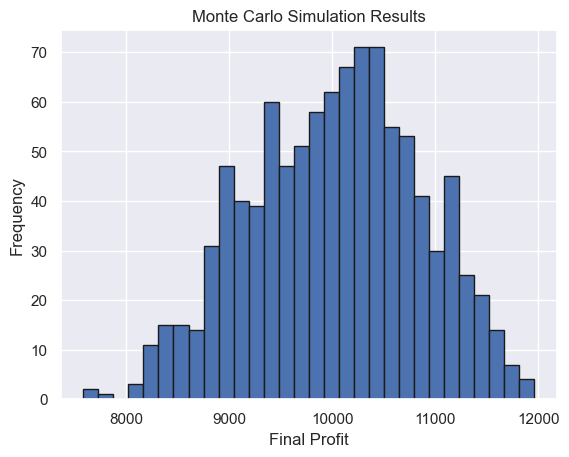

In [81]:
# Define simulation parameters
num_simulations = 1000
initial_capital = 10000

# Create lists to store simulation results
profits = []

# Monte Carlo simulation loop
for _ in range(num_simulations):
    # Generate random variations in strategy parameters
    random_near = random.randint(5, 10)  # Example: Vary near parameter 
    random_far = random.randint(40, 60)  # Example: Vary far parameter
    random_commission_rate = random.uniform(0.005, 0.02)  # Example: Vary commission_rate between 0.5% and 2%
    
    # Run the trade function with modified parameters
    transactions = trade(P1, P2, random_near, random_far, initial_capital, random_commission_rate, test=False)
    #print(transactions)
    # Calculate profit for this simulation
    if transactions:
        # Calculate profit for this simulation
        final_profit = transactions[-1]['pnl']
        profits.append(final_profit)

# Analyze simulation results
mean_profit = np.mean(profits)
std_deviation = np.std(profits)

print("Mean Profit:", mean_profit)
print("Standard Deviation:", std_deviation)

plt.hist(profits, bins=30, edgecolor='k')
plt.xlabel('Final Profit')
plt.ylabel('Frequency')
plt.title('Monte Carlo Simulation Results')
plt.show()
